# Real data application

In [1]:
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import verde as vd
import harmonica as hm
import euler
import pygmt
import xarray as xr
import pyproj

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data_dir = pathlib.Path("..") / "data"

In [4]:
data = pd.read_csv(data_dir / "rio-de-janeiro-magnetic.csv")
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number,easting_m,northing_m,geometric_height_m,geometric_flight_height_m,deriv_up,deriv_east,deriv_north
0,-42.640141,-22.290868,-16.56,151.49,2800,-4.393933e+06,-2.342247e+06,1257.78,1409.27,0.191043,0.017811,-0.096148
1,-42.640126,-22.291738,-43.47,162.46,2800,-4.393932e+06,-2.342343e+06,1281.78,1444.24,0.134332,0.025457,-0.116889
2,-42.640111,-22.292608,-65.38,170.69,2800,-4.393930e+06,-2.342440e+06,1247.78,1418.47,0.095537,0.036429,-0.151501
3,-42.640095,-22.293493,-74.29,173.43,2800,-4.393929e+06,-2.342538e+06,1194.78,1368.21,0.038966,0.052053,-0.195593
4,-42.640080,-22.294363,-67.20,170.08,2800,-4.393927e+06,-2.342634e+06,1192.78,1362.86,-0.050256,0.063334,-0.179654
...,...,...,...,...,...,...,...,...,...,...,...,...
50877,-41.905811,-22.497356,163.33,143.87,4600,-4.318263e+06,-2.365128e+06,1.35,145.22,-0.021278,0.000257,-0.043111
50878,-41.905811,-22.498226,175.29,142.34,4600,-4.318263e+06,-2.365225e+06,1.35,143.69,-0.032221,0.002482,-0.035659
50879,-41.905827,-22.499081,180.25,140.51,4600,-4.318265e+06,-2.365320e+06,-0.65,139.86,-0.040524,0.005149,-0.027047
50880,-41.905827,-22.499935,175.21,138.68,4600,-4.318265e+06,-2.365414e+06,0.35,139.03,-0.045282,0.007797,-0.017774


In [5]:
%%time
window_size = 12e3
window_step = window_size / 5
euler_windows = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.1,
).fit(
    coordinates=(data.easting_m.values, data.northing_m.values, data.geometric_flight_height_m.values),
    data=(
        data.total_field_anomaly_nT.values,
        data.deriv_east.values,
        data.deriv_north.values,
        data.deriv_up.values,
    ),
)

CPU times: user 653 ms, sys: 385 ms, total: 1.04 s
Wall time: 3.5 s


In [6]:
areas = [
    [-4.39e6, -4.375e6, -2.345e6, -2.33e6],
    [-4.365e6, -4.345e6, -2.35e6, -2.33e6],
    [-4.35e6, -4.335e6, -2.34e6, -2.325e6],
    [-4.35e6, -4.33e6, -2.36e6, -2.340e6],
]
area_solutions = []
area_names = "ABCDE"
for area in areas:
    data_area = data[vd.inside((data.easting_m, data.northing_m), area)]
    coordinates = (
        data_area.easting_m.values,
        data_area.northing_m.values,
        data_area.geometric_flight_height_m.values,
    )
    euler_data = (
        data_area.total_field_anomaly_nT.values,
        data_area.deriv_east.values,
        data_area.deriv_north.values,
        data_area.deriv_up.values,
    )
    candidates = []
    for si in [1, 2, 3]:
        candidates.append(
            euler.EulerInversion(structural_index=si).fit(coordinates, euler_data)
        )
    misfits = [ei.data_misfit_[1] for ei in candidates]
    best = candidates[np.argmin(misfits)]
    area_solutions.append(best)

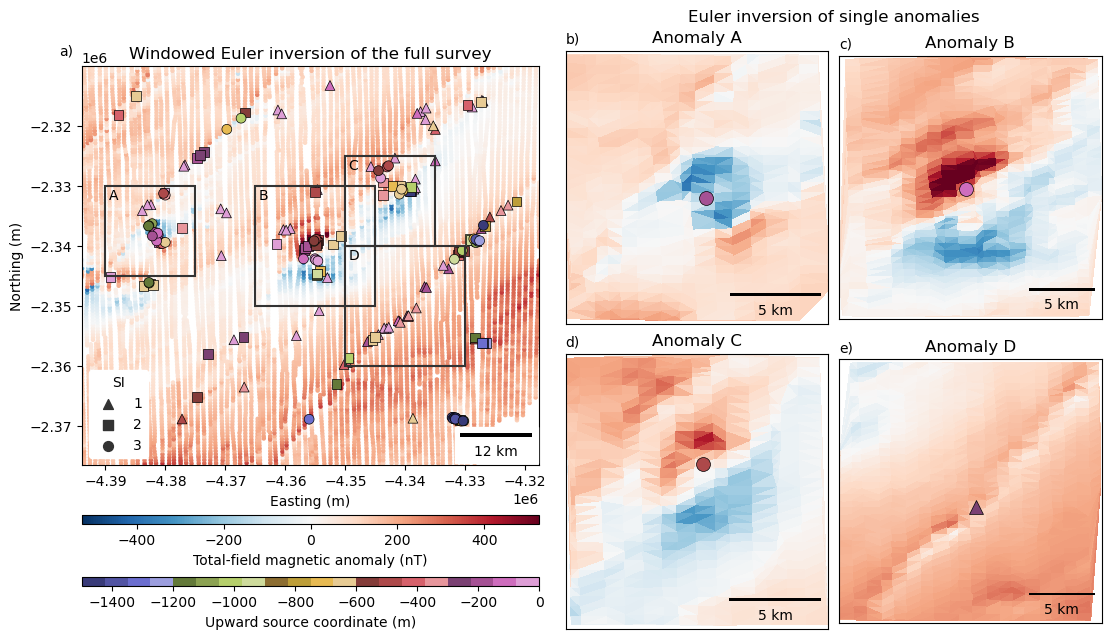

In [7]:
fig = plt.figure(figsize=(11, 6.3), layout="constrained")
figures = fig.subfigures(1, 2)

ax = figures[0].subplots(1, 1)
# figures[0].suptitle("Aeromagnetic data from Rio de Janeiro")
# scale = 0.9 * vd.maxabs(data.total_field_anomaly_nT)
scale = np.percentile(np.abs(data.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
    (data.easting_m, data.northing_m), data.total_field_anomaly_nT
)
tmp_data = ax.scatter(
    *block_coords, s=5, c=block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r"
)
ax.set_title("Windowed Euler inversion of the full survey")
ax.text(-0.05, 1.03, "a)", transform=ax.transAxes)
ax.set_aspect("equal")
ax.set_xlim(data.easting_m.min(), data.easting_m.max())
ax.set_ylim(data.northing_m.min(), data.northing_m.max())
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
markers = ["^", "s", "o"]
labels = {}
size = 50
vmin, vmax = -1500, 0
for si, marker in zip([1, 2, 3], markers):
    is_si = euler_windows.structural_indices_ == si
    tmp = ax.scatter(
        *euler_windows.locations_[:2, is_si],
        c=euler_windows.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.5,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)
ax.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.02,
    shrink=1,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)
fig.colorbar(
    tmp_data,
    ax=ax,
    aspect=50,
    pad=0.02,
    shrink=1,
    orientation="horizontal",
    label="Total-field magnetic anomaly (nT)",
)
ax.add_artist(
    ScaleBar(
        dx=0.001,
        fixed_value=window_size / 1000,
        units="km",
        location="lower right",
        # box_alpha=0,
        color="black",
        scale_loc="bottom",
        width_fraction=0.01,
        length_fraction=0.1,
        pad=0.4,
        scale_formatter=lambda value, unit: f"{value:.0f} {unit}",
    )
)

for area, name in zip(areas, area_names):
    ax.add_patch(
        plt.Rectangle(
            xy=(area[0], area[2]),
            width=area[1] - area[0],
            height=area[3] - area[2],
            fill=None,
            edgecolor="#333333",
            linewidth=1.5,
        )
    )
    ax.text(area[0] + 0.5e3, area[3] - 0.5e3, name, verticalalignment="top")

axes = figures[1].subplots(2, 2)
figures[1].suptitle("Euler inversion of single anomalies")
for area, name, ei, ax, label in zip(
    areas, area_names, area_solutions, axes.ravel(), "bcde"
):
    data_area = data[vd.inside((data.easting_m, data.northing_m), area)]
    block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
        (data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT
    )
    ax.tripcolor(*block_coords, block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
    ax.set_aspect("equal")
    ax.set_xlim(data_area.easting_m.min(), data_area.easting_m.max())
    ax.set_ylim(data_area.northing_m.min(), data_area.northing_m.max())
    ax.set_title(f"Anomaly {name}")
    ax.tick_params(
        axis="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    tmp = ax.scatter(
        *ei.location_[:2],
        c=ei.location_[2],
        s=100,
        marker=markers[ei.structural_index - 1],
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.5,
        cmap="tab20b",
    )
    ax.add_artist(
        ScaleBar(
            dx=1,
            units="m",
            location="lower right",
            box_alpha=0,
            color="black",
            scale_loc="bottom",
            width_fraction=0.01,
            length_fraction=0.5,
            pad=0.4,
        )
    )
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)

# for dpi, res in zip([70, 300], ["", "-highres"]):
#     fig.savefig(
#         f"../paper/figures/real-data-application{res}.png",
#         dpi=dpi,
#         bbox_inches="tight",
#     )

plt.show()

## Convert Euler results from heights to depths

In [8]:
region = [-42.64, -41.9, -22.6, -22]

In [9]:
# orthomrtric height
topography = pygmt.datasets.load_earth_relief(resolution="01s", region=region)
topography = topography.rename({'lon': 'longitude', 'lat': 'latitude'})
# geoid height
geoid = pygmt.datasets.load_earth_geoid(resolution="01m", region=region, registration="gridline")
geoid = geoid.rename({'lon': 'longitude', 'lat': 'latitude'})

In [10]:
# Interpolate the geoid to 1s resolution
interpolator = vd.KNeighbors()

geoid_table = vd.grid_to_table(geoid)
topography_table = vd.grid_to_table(topography)

interpolator.fit((geoid_table.longitude, geoid_table.latitude), geoid_table.z)
topography_table = topography_table.assign(elevation=interpolator.predict((topography_table.longitude, topography_table.latitude)))

geoid_values = np.reshape(topography_table.elevation, topography.shape)
geoid = xr.DataArray(geoid_values, coords=[topography.latitude, topography.longitude], dims=['latitude', 'longitude'])

In [11]:
# geometric height
topography_geometric = topography + geoid

In [12]:
table = vd.grid_to_table(topography_geometric)
table.head()

,latitude,longitude,scalars
0,-22.6,-42.641667,402.38
1,-22.6,-42.641389,417.39
2,-22.6,-42.641111,429.39
3,-22.6,-42.640833,440.39
4,-22.6,-42.640556,448.39


In [13]:
projection = pyproj.Proj(proj="merc", lat_ts=table.latitude.mean())
table = table.assign(
    **{
        name: coord
        for name, coord in zip(
            ["easting_m", "northing_m"], projection(table.longitude, table.latitude)
        )
    }
)
table.rename(columns={'scalars': 'z'}, inplace=True)
table.head()

,latitude,longitude,z,easting_m,northing_m
0,-22.6,-42.641667,402.38,-4.393949e+06,-2.376439e+06
1,-22.6,-42.641389,417.39,-4.393920e+06,-2.376439e+06
2,-22.6,-42.641111,429.39,-4.393891e+06,-2.376439e+06
3,-22.6,-42.640833,440.39,-4.393863e+06,-2.376439e+06
4,-22.6,-42.640556,448.39,-4.393834e+06,-2.376439e+06


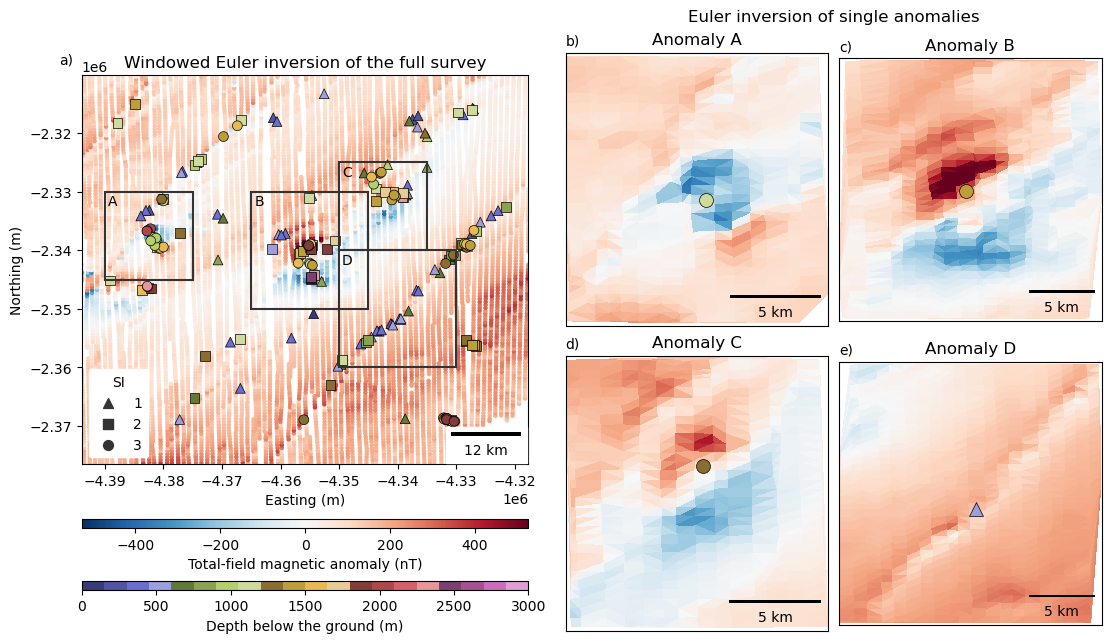

In [15]:
fig = plt.figure(figsize=(11, 6.3), layout="constrained")
figures = fig.subfigures(1, 2)

ax = figures[0].subplots(1, 1)
# figures[0].suptitle("Aeromagnetic data from Rio de Janeiro")
# scale = 0.9 * vd.maxabs(data.total_field_anomaly_nT)
scale = np.percentile(np.abs(data.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
    (data.easting_m, data.northing_m), data.total_field_anomaly_nT
)
tmp_data = ax.scatter(
    *block_coords, s=5, c=block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r"
)
ax.set_title("Windowed Euler inversion of the full survey")
ax.text(-0.05, 1.03, "a)", transform=ax.transAxes)
ax.set_aspect("equal")
ax.set_xlim(data.easting_m.min(), data.easting_m.max())
ax.set_ylim(data.northing_m.min(), data.northing_m.max())
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
markers = ["^", "s", "o"]
labels = {}
size = 50
vmin, vmax = 0, 3000
for si, marker in zip([1, 2, 3], markers):
    is_si = euler_windows.structural_indices_ == si

    # interpolator
    interpolator.fit((table.easting_m, table.northing_m), table.z)
    predicted_h = interpolator.predict((euler_windows.locations_[:2, is_si][0], euler_windows.locations_[:2, is_si][1]))
    depths = predicted_h - euler_windows.locations_[2, is_si]
    
    tmp = ax.scatter(
        *euler_windows.locations_[:2, is_si],
        c=depths,
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.5,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)
ax.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.02,
    shrink=1,
    orientation="horizontal",
    label="Depth below the ground (m)",
)
fig.colorbar(
    tmp_data,
    ax=ax,
    aspect=50,
    pad=0.02,
    shrink=1,
    orientation="horizontal",
    label="Total-field magnetic anomaly (nT)",
)
ax.add_artist(
    ScaleBar(
        dx=0.001,
        fixed_value=window_size / 1000,
        units="km",
        location="lower right",
        # box_alpha=0,
        color="black",
        scale_loc="bottom",
        width_fraction=0.01,
        length_fraction=0.1,
        pad=0.4,
        scale_formatter=lambda value, unit: f"{value:.0f} {unit}",
    )
)

for area, name in zip(areas, area_names):
    ax.add_patch(
        plt.Rectangle(
            xy=(area[0], area[2]),
            width=area[1] - area[0],
            height=area[3] - area[2],
            fill=None,
            edgecolor="#333333",
            linewidth=1.5,
        )
    )
    ax.text(area[0] + 0.5e3, area[3] - 0.5e3, name, verticalalignment="top")

axes = figures[1].subplots(2, 2)
figures[1].suptitle("Euler inversion of single anomalies")
for area, name, ei, ax, label in zip(
    areas, area_names, area_solutions, axes.ravel(), "bcde"
):
    data_area = data[vd.inside((data.easting_m, data.northing_m), area)]
    block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
        (data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT
    )
    ax.tripcolor(*block_coords, block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
    ax.set_aspect("equal")
    ax.set_xlim(data_area.easting_m.min(), data_area.easting_m.max())
    ax.set_ylim(data_area.northing_m.min(), data_area.northing_m.max())
    ax.set_title(f"Anomaly {name}")
    ax.tick_params(
        axis="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    # Interpolater
    interpolator.fit((table.easting_m, table.northing_m), table.z)
    predicted_h = interpolator.predict((ei.location_[0], ei.location_[1]))
    depth = predicted_h - ei.location_[2] 

    
    tmp = ax.scatter(
        *ei.location_[:2],
        c=depth,
        s=100,
        marker=markers[ei.structural_index - 1],
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.5,
        cmap="tab20b",
    )
    ax.add_artist(
        ScaleBar(
            dx=1,
            units="m",
            location="lower right",
            box_alpha=0,
            color="black",
            scale_loc="bottom",
            width_fraction=0.01,
            length_fraction=0.5,
            pad=0.4,
        )
    )
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)

for dpi, res in zip([70, 300], ["", "-highres"]):
    fig.savefig(
        f"../paper/figures/real-data-application{res}.png",
        dpi=dpi,
        bbox_inches="tight",
    )

plt.show()